In [1]:
#import imageio
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from imblearn.over_sampling import SMOTE
from collections import Counter



# To Avoid GPU errors
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
directory = 'The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

x = np.empty(shape=(1097,224,224,3))

In [5]:
count = 0
for i in categories:
    path = os.path.join(directory, i)
    
    
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = image.load_img(filepath, target_size = (224,224))
        arr = image.img_to_array(img)
        
        x[count]=arr
        count +=1

In [8]:
x.shape

(1097, 224, 224, 3)

In [9]:
#Label = {0: 'Bengin',1: 'Malignant',2:'Normal'}
y = [0]*120+ [1]*561 + [2]*416
y = np. array(y)
y = to_categorical(y)
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [10]:
y.shape

(1097, 3)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

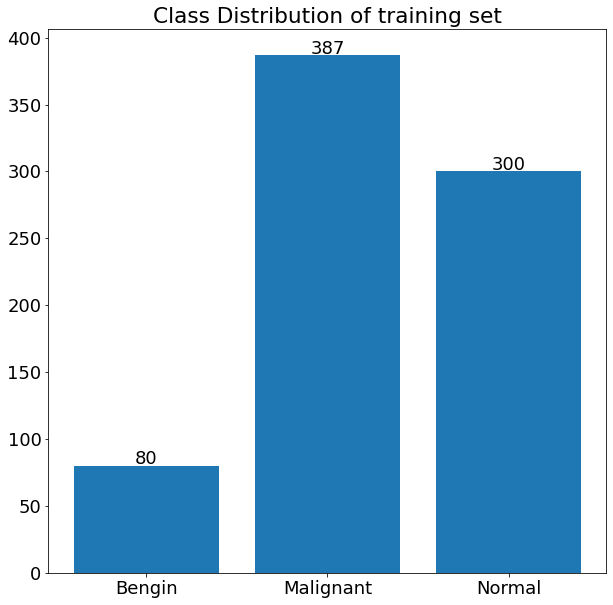

In [72]:
train_label = np.array([x.argmax() for x in y_train])
train_label.sort()

plt.figure(figsize = (10,10))
labels, values = zip(*Counter(train_label).items())

indexes = np.arange(len(labels))
width = 0.8

plt.bar(indexes, values, width)
# zip joins x and y coordinates in pairs
for x,y in zip(indexes, values):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,1.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.xticks(indexes , ['Bengin', 'Malignant', 'Normal'])
plt.title('Class Distribution of training set')

plt.show()

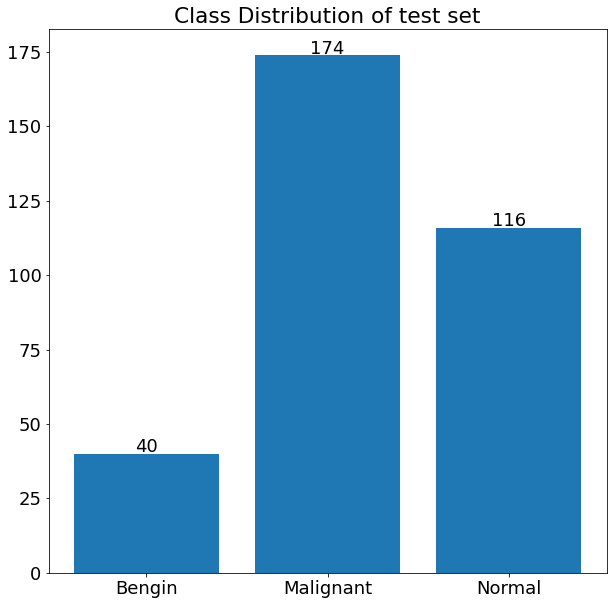

In [75]:
test_label = np.array([x.argmax() for x in y_test])
test_label.sort()
plt.figure(figsize = (10,10))
labels, values = zip(*Counter(test_label).items())

indexes = np.arange(len(labels))
width = 0.8

plt.bar(indexes, values, width)
# zip joins x and y coordinates in pairs
for x,y in zip(indexes, values):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,1.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.xticks(indexes , ['Bengin', 'Malignant', 'Normal'])
plt.title('Class Distribution of test set')
plt.show()

In [13]:
#pre-process
pp_X_train = vgg16.preprocess_input(X_train)
pp_X_test = vgg16.preprocess_input(X_test)

In [14]:
base_model = VGG16(include_top=True)
#base_model.save('VGG16')

In [15]:
#base_model = keras.models.load_model('VGG16')


In [16]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
def NN_model(model,lr = 0.001,opt = keras.optimizers.Adam ):   
    # Freeze all model layer weights
    model.trainable = False
    # choose other than simply removing the last one 
    base_inputs = model.layers[0].input
    base_outputs = model.layers[-2].output

    

    layer1 = layers.Dense(512, activation="relu",name = 'new_layer2')(base_outputs)

    layer2 = layers.Dense(256, activation="relu",name = 'new_layer3')(layer1)

    classifier = layers.Dense(3, activation="softmax",name = 'new_predictions')(layer2) #3-level classifier
    new_model = keras.Model(inputs=base_inputs, outputs=classifier)
    new_model.compile(
        optimizer= opt(learning_rate = lr),
        loss='categorical_crossentropy',
        metrics=["accuracy"])
    return new_model

In [18]:
def plot_acc(history):
    fig, ax = plt.subplots(1, 2, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    plt.rcParams.update({'font.size': 18})

    # Plot training & validation accuracy values
    ax[0].plot(history.history['accuracy'], label = 'Training')
    ax[0].plot(history.history['val_accuracy'], label = 'Validation')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()

    # Plot training & validation loss values
    ax[1].plot(history.history['loss'], label = 'Training')
    ax[1].plot(history.history['val_loss'], label = 'Validation')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    plt.show()

In [18]:
new_model_1 = NN_model(model = base_model)

In [19]:
new_model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
%%time
hist= new_model_1.fit(pp_X_train,y_train, epochs=15, verbose=1,batch_size =16,validation_split = 0.2)

Epoch 1/15
39/39 [==============================] - 25s 374ms/step - loss: 0.7949 - accuracy: 0.7977 - val_loss: 0.3460 - val_accuracy: 0.8701
Epoch 2/15
39/39 [==============================] - 8s 216ms/step - loss: 0.2153 - accuracy: 0.9168 - val_loss: 0.2345 - val_accuracy: 0.9091
Epoch 3/15
39/39 [==============================] - 14s 374ms/step - loss: 0.1714 - accuracy: 0.9282 - val_loss: 0.3360 - val_accuracy: 0.8831
Epoch 4/15
39/39 [==============================] - 17s 444ms/step - loss: 0.1268 - accuracy: 0.9560 - val_loss: 0.3117 - val_accuracy: 0.9026
Epoch 5/15
39/39 [==============================] - 18s 466ms/step - loss: 0.0831 - accuracy: 0.9641 - val_loss: 0.2813 - val_accuracy: 0.9026
Epoch 6/15
39/39 [==============================] - 18s 473ms/step - loss: 0.1387 - accuracy: 0.9429 - val_loss: 0.4314 - val_accuracy: 0.9026
Epoch 7/15
39/39 [==============================] - 15s 395ms/step - loss: 0.1460 - accuracy: 0.9364 - val_loss: 0.2732 - val_accuracy: 0.9026


In [21]:
test_Loss, test_accuracy =new_model_1.evaluate(pp_X_test,y_test,batch_size=16)

21/21 [==============================] - 5s 245ms/step - loss: 0.3597 - accuracy: 0.92120s - loss: 0.3597 - accuracy: 0.92


In [22]:
print('Test Loss = %.3f' %test_Loss)
print('Test Accuracy = %.3f' %test_accuracy)

Test Loss = 0.360
Test Accuracy = 0.921


In [23]:
#new_model_1.save('trained_VGG_1')

In [25]:
Y_pred = new_model_1.predict(pp_X_test,batch_size=16)
y_pred = np.argmax(Y_pred, axis=1)

actual_label = np.array([x.argmax() for x in y_test])

target_names = ['Bengin', 'Malignant', 'Normal']
print(classification_report(actual_label, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Bengin       1.00      0.38      0.55        40
   Malignant       1.00      0.99      1.00       174
      Normal       0.82      1.00      0.90       116

    accuracy                           0.92       330
   macro avg       0.94      0.79      0.81       330
weighted avg       0.94      0.92      0.91       330



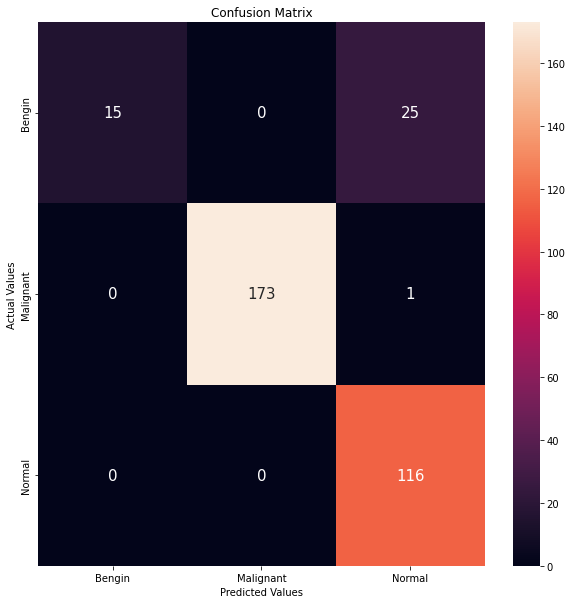

In [26]:

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(confusion_matrix(actual_label, y_pred))
cm_df.columns=['Bengin', 'Malignant', 'Normal']
cm_df.index=['Bengin', 'Malignant', 'Normal']
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,fmt='',annot_kws={'size': 15})
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

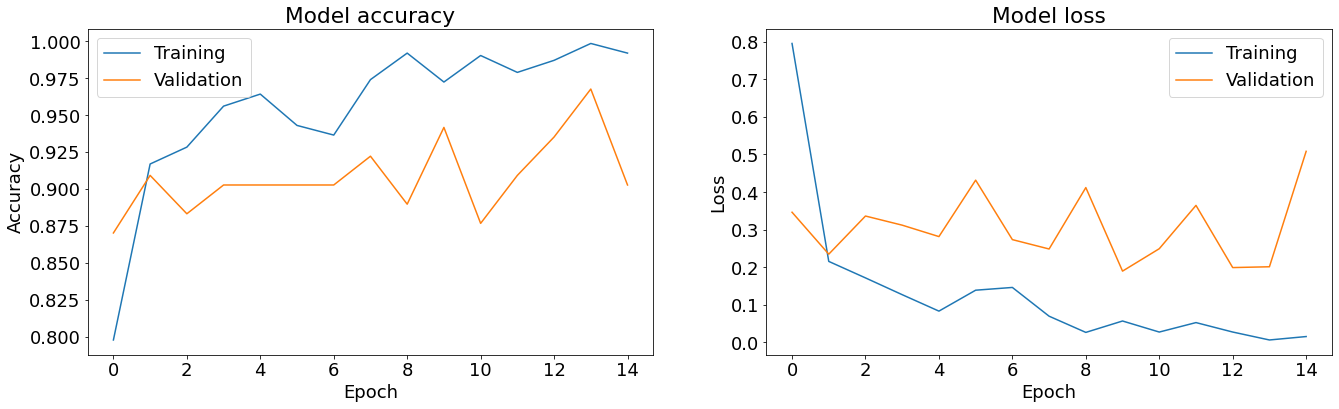

In [57]:
plot_acc(hist)

### Image Augmentation 

In [30]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train_label)[0]),
    1: X_train.shape[0]/(3*Counter(y_train_label)[1]),
    2: X_train.shape[0]/(3*Counter(y_train_label)[2]),
}



new_weights

{0: 3.1958333333333333, 1: 0.6606373815676141, 2: 0.8522222222222222}

In [31]:
# create image data augmentation generator
train_datagen = ImageDataGenerator(

    preprocessing_function=vgg16.preprocess_input,
    vertical_flip= True,
    
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

In [32]:
new_model_2 = NN_model(model = base_model)

In [33]:
X_train.shape

(767, 224, 224, 3)

In [34]:
%%time
hist_2=new_model_2.fit(train_datagen.flow(X_train, y_train, batch_size=16,
         subset='training'),
         validation_data=train_datagen.flow(X_train, y_train,
         batch_size=16, subset='validation'), epochs=15,class_weight=new_weights)

Epoch 1/15
39/39 [==============================] - 34s 872ms/step - loss: 1.4075 - accuracy: 0.7085 - val_loss: 0.2920 - val_accuracy: 0.8431
Epoch 2/15
39/39 [==============================] - 24s 625ms/step - loss: 0.5995 - accuracy: 0.8029 - val_loss: 0.5089 - val_accuracy: 0.7647
Epoch 3/15
39/39 [==============================] - 23s 593ms/step - loss: 0.5004 - accuracy: 0.8062 - val_loss: 0.5704 - val_accuracy: 0.6993
Epoch 4/15
39/39 [==============================] - 13s 342ms/step - loss: 0.4084 - accuracy: 0.8502 - val_loss: 0.3217 - val_accuracy: 0.8562
Epoch 5/15
39/39 [==============================] - 13s 326ms/step - loss: 0.3116 - accuracy: 0.8909 - val_loss: 0.4529 - val_accuracy: 0.8039
Epoch 6/15
39/39 [==============================] - 20s 531ms/step - loss: 0.3612 - accuracy: 0.8583 - val_loss: 0.1841 - val_accuracy: 0.9150
Epoch 7/15
39/39 [==============================] - 21s 549ms/step - loss: 0.2410 - accuracy: 0.9169 - val_loss: 0.3136 - val_accuracy: 0.8758

In [35]:

test_Loss,test_accuracy=new_model_2.evaluate(test_datagen.flow(X_test, y_test, batch_size=16))

21/21 [==============================] - 11s 538ms/step - loss: 0.2638 - accuracy: 0.9121


[0.2637671232223511, 0.9121212363243103]

In [2]:
print('Test Loss = %.3f' %test_Loss)
print('Test Accuracy = %.3f' %test_accuracy)

Test Loss = 0.264
Test Accuracy = 0.912


In [37]:
Y_pred = new_model_2.predict(pp_X_test, batch_size=16)
y_pred = np.argmax(Y_pred, axis=1)

actual_label = np.array([x.argmax() for x in y_test])

target_names = ['Bengin', 'Malignant', 'Normal']
print(classification_report(actual_label, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Bengin       0.50      0.97      0.66        40
   Malignant       0.98      0.98      0.98       174
      Normal       0.99      0.66      0.79       116

    accuracy                           0.87       330
   macro avg       0.82      0.87      0.81       330
weighted avg       0.92      0.87      0.87       330



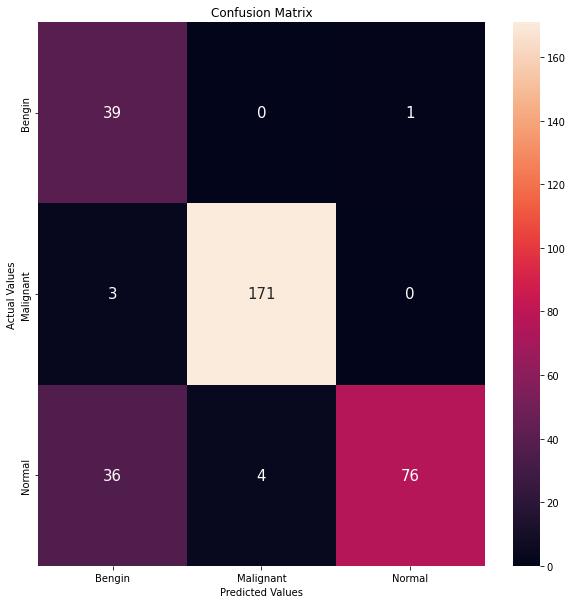

In [38]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(confusion_matrix(actual_label, y_pred))
cm_df.columns=['Bengin', 'Malignant', 'Normal']
cm_df.index=['Bengin', 'Malignant', 'Normal']
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,fmt='',annot_kws={'size': 15})
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

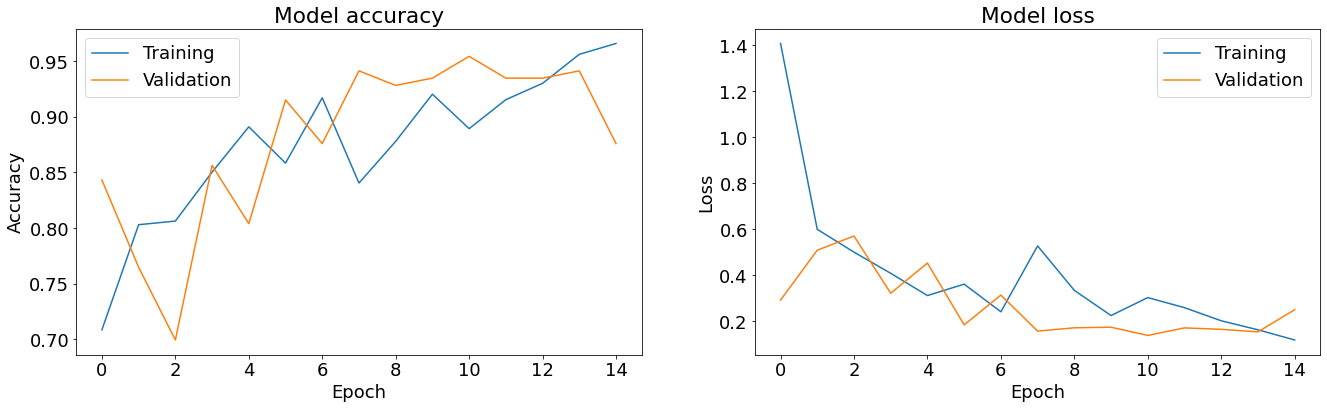

In [58]:
plot_acc(hist_2)

# SMOTE oversampling method

In [44]:
y_train_label = np.argmax(y_train, axis=1)
X_train_flatten = X_train.reshape(X_train.shape[0], 224*224*3)

print('Before SMOTE:', Counter(y_train_label))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train_flatten, y_train_label)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 387, 2: 300, 0: 80})
After SMOTE: Counter({1: 387, 2: 387, 0: 387})


In [45]:
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0],224, 224, 3)
X_train_sampled = vgg16.preprocess_input(X_train_sampled)
y_train_sampled= to_categorical(y_train_sampled)

In [47]:
print('Shape of X',X_train_sampled.shape)
print('Shape of Y',y_train_sampled.shape)

Shape of X (1161, 224, 224, 3)
Shape of Y (1161, 3)


In [48]:
new_model_3 = NN_model(model = base_model)

In [49]:
#tensorboard_callback = keras.callbacks.TensorBoard(
    #log_dir="tb_callback_dir", histogram_freq=1,)

In [50]:
%%time
hist_3= new_model_3.fit(X_train_sampled,y_train_sampled, epochs=15, verbose=1,batch_size =16,validation_split = 0.2)

Epoch 1/15
58/58 [==============================] - 14s 230ms/step - loss: 1.0216 - accuracy: 0.7575 - val_loss: 0.4830 - val_accuracy: 0.8412
Epoch 2/15
58/58 [==============================] - 36s 628ms/step - loss: 0.1980 - accuracy: 0.9106 - val_loss: 0.3976 - val_accuracy: 0.8627
Epoch 3/15
58/58 [==============================] - 40s 681ms/step - loss: 0.1379 - accuracy: 0.9472 - val_loss: 0.9305 - val_accuracy: 0.7468
Epoch 4/15
58/58 [==============================] - 35s 602ms/step - loss: 0.1866 - accuracy: 0.9267 - val_loss: 0.4284 - val_accuracy: 0.8798
Epoch 5/15
58/58 [==============================] - 28s 490ms/step - loss: 0.0766 - accuracy: 0.9720 - val_loss: 0.2531 - val_accuracy: 0.9142
Epoch 6/15
58/58 [==============================] - 27s 475ms/step - loss: 0.0554 - accuracy: 0.9806 - val_loss: 0.3196 - val_accuracy: 0.9056
Epoch 7/15
58/58 [==============================] - 33s 576ms/step - loss: 0.0284 - accuracy: 0.9935 - val_loss: 0.2607 - val_accuracy: 0.9099

In [51]:
test_Loss, test_accuracy =new_model_3.evaluate(pp_X_test,y_test,batch_size=4)

83/83 [==============================] - 25s 301ms/step - loss: 0.5383 - accuracy: 0.8455


In [4]:
print('Test Loss = %.3f' %test_Loss)
print('Test Accuracy = %.3f' %test_accuracy)

Test Loss = 0.538
Test Accuracy = 0.846


In [54]:
Y_pred = new_model_3.predict(pp_X_test,batch_size=8)
y_pred = np.argmax(Y_pred, axis=1)

actual_label = np.array([x.argmax() for x in y_test])

target_names = ['Bengin', 'Malignant', 'Normal']
print(classification_report(actual_label, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Bengin       0.45      0.97      0.62        40
   Malignant       0.98      0.93      0.96       174
      Normal       0.99      0.67      0.80       116

    accuracy                           0.85       330
   macro avg       0.81      0.86      0.79       330
weighted avg       0.92      0.85      0.86       330



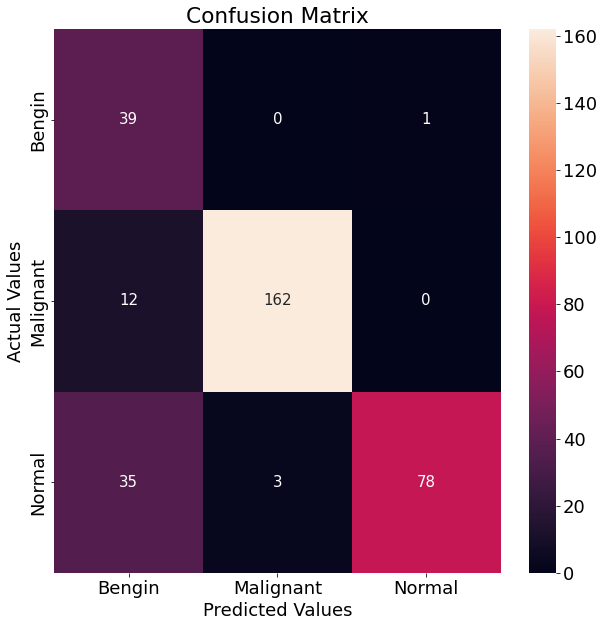

In [55]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(confusion_matrix(actual_label, y_pred))
cm_df.columns=['Bengin', 'Malignant', 'Normal']
cm_df.index=['Bengin', 'Malignant', 'Normal']
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,fmt='',annot_kws={'size': 15})
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

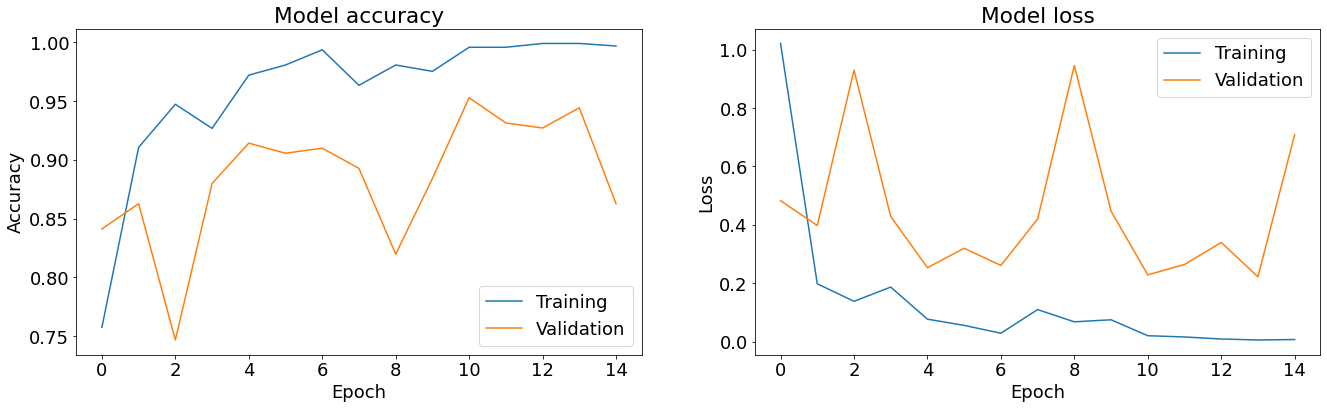

In [56]:
plot_acc(hist_3)